This is a script to see if we can develop a way to efficient fit "bump" functions. 

By "bump" function we mean a function: 

    1) Which has finite support
    2) Is parameterized by a location (e.g., center) that can move
    3) May have other parameters (e.g., bandwidth, magnitude)
    
The chief difficulties we face are: 

    1) How do we fit these functions when they may be initialized so there locations are in a bad initial place.  In these cases, there may be zero gradients for location.  Our solution here is to add terms to the optimization objective that encourage "wandering" when gradients are small. 
    
    2) With the finite support, many data points will evaluate to 0.  We would like to avoid wasting computation on these.  We achieve this by selecting only points within the support to do computation for. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Callable, Sequence

import matplotlib.pyplot as plt
import numpy as np
import torch
import time

from janelia_core.ml.utils import torch_mod_to_fcn

### BumpFcn

In [3]:
class BumpFcn(torch.nn.Module):
    
    def __init__(self, ctr: torch.Tensor, band_widths: torch.Tensor, mag: float, support_p: float = .01):
        """ Creates a bump function with initial values. 
        
        We use exponential functions of the form y(x) = mag*exp(-d), where
        d = sum[((x - ctr)**2)/band_widths]
        
        Args:
        
            ctr: The initial center
            
            band_widths: The initial band widths
            
            mag: The initial magnitude 
            
            support_p: The percent of max value in any direction where we define the boundary of support
        
        """
        super().__init__()
        
        self.ctr = torch.nn.Parameter(ctr)
        self.band_widths = torch.nn.Parameter(band_widths)
        self.mag = torch.nn.Parameter(torch.Tensor([mag]))
        self.support_p = support_p
        self.support_k = np.sqrt(-1*np.log(support_p))
        
    def forward(self, x: torch.Tensor, small_output: bool = False) -> torch.Tensor:
        """ Computes output from input. 
        
        Args:
            x: Input of shape n_smps*d_in
            
        Returns: 
            y: Output of shape n_smps
        """
        
        n_smps = x.shape[0]
        
        # Find points in support 
        min_bounds = -1*self.support_k*self.band_widths + self.ctr
        max_bounds = self.support_k*self.band_widths + self.ctr
        lower_bound_inds = x > min_bounds
        upper_bound_inds = x < max_bounds
        calc_pts = (torch.all(lower_bound_inds & upper_bound_inds, dim=1)).nonzero().squeeze(dim=1)
        
        # Make sure we always calculate output for at least 1 input - this ensures gradients are set
        if calc_pts.nelement() == 0:
            calc_pts = torch.tensor([0], dtype=torch.long)
        
        if not small_output:
            y = torch.zeros(n_smps, device=x.device)
            y[calc_pts] = self.mag*torch.exp(-1*torch.sum(((x[calc_pts,:] - self.ctr)/self.band_widths)**2, dim=1))
            return y
        else:
            return [calc_pts, self.mag*torch.exp(-1*torch.sum(((x[calc_pts,:] - self.ctr)/self.band_widths)**2, dim=1))]

        #return self.mag*torch.exp(-1*torch.sum(((x - self.ctr)/self.band_widths)**2, dim=1))
        
    
    def bound(self, ctr_bounds: Sequence = [0, 1], 
              bandwidth_bounds: Sequence = [.01, .3]):
        
        if ctr_bounds is not None:
            small_inds = self.ctr < ctr_bounds[0]
            big_inds = self.ctr > ctr_bounds[1]
            self.ctr.data[small_inds] = ctr_bounds[0]
            self.ctr.data[big_inds] = ctr_bounds[0]
            
        if bandwidth_bounds is not None:
            small_inds = self.band_widths < bandwidth_bounds[0]
            big_inds = self.band_widths > bandwidth_bounds[1]
            self.band_widths.data[small_inds] = bandwidth_bounds[0]
            self.band_widths.data[big_inds] = bandwidth_bounds[1]
            
    def add_noise_to_grads(self, center_k: float = .01, mag_k: float = .01, 
                           bandwidth_k: float = .01):

        if center_k != 0:
            ctr_grad_noise = torch.randn(2, device=self.ctr.device)
            self.ctr._grad += center_k*ctr_grad_noise
        
        if mag_k != 0:
            self.mag._grad += mag_k*self.mag
            
        if bandwidth_k != 0: 
            bound_grad_noise = torch.randn(2, device=self.band_widths.device)
            self.band_widths._grad += bandwidth_k*bound_grad_noise
        

## Sum of Bump Functions

In [4]:
class SumOfBumpFcns(torch.nn.Module):
    
    def __init__(self, n_bumps: int, ctr_range: np.ndarray = None, bandwidth_range: np.ndarray = None, 
                 mag_range: np.ndarray = None, support_p: float = .01):
        """ Creates a new SumOfBumpFcns module.
        
        Args:
        
            ctr_range: Range to randomly create centers in.  ctr_range[i,:] gives the range for dimension i. 
            
            bandwidth_range: Range to create bandwidths in.  bandwidth_range[i,:] gives the range for dimension i. 
            
            mag_range: Range to create magnitudes in. 
            
            support_p: The value of support_p for each bump function. 
            
        """
        super().__init__()
        
        if ctr_range is None:
            ctr_range = np.asarray([[0, 1.0], [0, 1]])
            
        if bandwidth_range is None:
            bandwidth_range = np.asarray([[.1, 1], [.1, 1]])
        
        if mag_range is None:
            mag_range = np.asarray([-.1, .1])
        
        # Convert range parameters to torch tensors.  Here we set the data type of these tensors to the torch default.
        ctr_range = torch.tensor(ctr_range, dtype=torch.get_default_dtype())
        bandwidth_range = torch.tensor(bandwidth_range, dtype=torch.get_default_dtype())
        mag_range = torch.tensor(mag_range, dtype=torch.get_default_dtype())
        
        n_dims = ctr_range.shape[0]
        ctr_w = ctr_range[:,1] - ctr_range[:,0]
        bandwidth_w = bandwidth_range[:,1] - bandwidth_range[:,0]
        mag_w = mag_range[1] - mag_range[0]
             
        bump_fcns = [BumpFcn(ctr=torch.rand(n_dims)*ctr_w + ctr_range[:,0],
                             band_widths=torch.rand(n_dims)*bandwidth_w + bandwidth_range[:,0],
                             mag=torch.rand(1)*mag_w + mag_range[0],
                             support_p=support_p) for b_i in range(n_bumps)]
        
        self.bump_fcns = torch.nn.ModuleList(bump_fcns)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Computes output from input. 
        
        Args:
            x: Input of shape n_smps*d_in
            
        Returns: 
            y: Output of shape n_smps
        """
    
        
        # TODO: Is concatenation most efficient below?  What about a loop and then just sum in the loop? Can
        # we evaluate all the bump functions in parallel on the GPU?
        return torch.sum(torch.stack([b_f(x) for b_f in self.bump_fcns]), dim=0)
    
        #n_smps = x.shape[0]
        #y = torch.zeros(n_smps)
        #for b_f in self.bump_fcns:
        #    pts_in_support, vls = b_f(x, small_output=True)
        #    y[pts_in_support] += vls
        #return y
    
    def bound(self, ctr_bounds: Sequence = [0, 1], 
                    bandwidth_bounds: Sequence = [.01, .3]):
        
        for b_f in self.bump_fcns:
            b_f.bound(ctr_bounds=ctr_bounds, bandwidth_bounds=bandwidth_bounds)
            
    def add_noise_to_grads(self, center_k: float = .01, mag_k: float = .01, 
                           bandwidth_k: float = .01):
        for b_f in self.bump_fcns:
            b_f.add_noise_to_grads(center_k=center_k, mag_k=mag_k, bandwidth_k=bandwidth_k)

## Object for creating random functions

In [5]:
class F_t():
    """
    An object for generating a sequence of functions on the unit hypercube. 
    
    The function f_t is formed as t*f_base, where f_base is a base function
    made up of a sum of Gaussian bumps.  
    
    Bump centers will be uniformly distributed throughout the hypercube.  Bump
    magnitudes and shapes (how fast they fall off in different directions) will
    be randomly generated according to parameters set by the user. 
    
    """
    
    def __init__(self, d: int = 2, n_bumps: int = 100, 
                 bump_peak_vl_range: Sequence[int] = [-1, 1], 
                 cov_ev_range: Sequence[int] = [.5, 1]):
        """
        Creates a new F_t object. 
    
        Args:
            d: The input dimensionality. 
        
            n_bumps: The number of Gaussian bumps in the base function. 
        
            bump_peak_vl_range: Values for the peak of each bump function will be pulled
            uniformly from this interval. 
        
            cov_ev_range: Values for the eigenvalues of the covariance matrix of the 
            Gaussian bump functions will be pulled uniformly from this range. 
    
        """
    
        self.d = d
        self.n_bumps = n_bumps
        
        self.ctrs = np.random.uniform(size=[n_bumps, d])
        self.peak_vls = np.random.uniform(low=bump_peak_vl_range[0], 
                                          high=bump_peak_vl_range[1],
                                          size=n_bumps)
        
        # Generate the covariance for each bump function 
        eig_vls = np.random.uniform(low=cov_ev_range[0], 
                                          high=cov_ev_range[1],
                                          size=[n_bumps, d])
        
        inv_covs = np.zeros([d, d, n_bumps])
        for b_i in range(n_bumps):
            # Generate a random orthogonal matrix 
            u_i = np.linalg.svd(np.random.randn(d,d))[0]
            eig_vls_i = np.diag(1/eig_vls[b_i,:])
            inv_covs[:,:, b_i] = np.matmul(np.matmul(u_i, eig_vls_i), u_i.transpose())
            
        self.inv_covs = inv_covs
        
    def _f(self, x: np.ndarray) -> np.ndarray:
        """ Computes output given input. 
           
        Args:
            x: input of shape n_smps*d_in.  
            
        Returns:
            y: output of shape n_smps
        """
        
        n_smps = x.shape[0]
        
        y = np.zeros(n_smps)
        
        for b_i in range(self.n_bumps):
            x_ctr = x - self.ctrs[b_i,:]
            
            inv_cov_i = np.squeeze(self.inv_covs[:, :, b_i])
            
            temp = np.squeeze(np.sum(np.matmul(x_ctr, inv_cov_i.transpose())*x_ctr,1))
            
            y += self.peak_vls[b_i]*np.exp(-1*temp)
        
        return y
    
    def generate(self, scale: float = 1.0) -> Callable:
        """ Generates a function at a given scale. 
        
        Args:
            f: The scale to generate the function at
        """
        
        def s_f(x):
            return scale*self._f(x)
        
        return s_f

In [6]:
def generate_pts(d: int = 2, n_smps_per_dim = 100):
    """ Generates points on a hyper grid for evaluating a function.
    
    Args:
        d: The dimensionality of the grid. 
        
        n_smps_per_dim: The number of samples per dimension to generate. 
    """
    
    dim_coords = (1/n_smps_per_dim)*np.arange(n_smps_per_dim)
    all_coords = [dim_coords]*d
    grid_coords = np.meshgrid(*all_coords)
    coords = np.stack([np.ravel(g) for g in grid_coords]).transpose()
    
    return coords

In [7]:
def plot_2d_f(f: Callable, n_smps_per_dim = 100):
    """ Plots a 2-d function on the unit square. 
    
    Args:
        f: The function to plot
        
        n_smps_per_dim: The number of samples per dimension to use when generating
        a grid to use for visualizing the function. 
    """
    
    pts = generate_pts(d = 2, n_smps_per_dim=n_smps_per_dim)  
    
    y_grid = f(pts).reshape([n_smps_per_dim, n_smps_per_dim])
    
    plt.imshow(y_grid)
    plt.colorbar()
    

In [8]:
def fit(nn: torch.nn.Module, x: torch.Tensor, y: torch.Tensor, n_its = 1000, lr=.01, batch_size: int = None, 
        enforce_bounds: bool = True, center_k: float = 0.0, mag_k: float = 0.0, 
        bandwidth_k: float = 0.0, update_int: int = 1000):
    """ Fits a neural network. 
    
    Args:
        x: Input data of shape n_smps*d_in
        
        y: Output data of shape n_smps*1
        
        n_its: The number of iterations to run optimization for
        
        lr: The learning rate to use
        
        enforce_bounds: If true, the center of bump functions will be
        constrained to stay in the unit hypercube
    
    """
    
    params = nn.parameters()
    
    optimizer = torch.optim.Adam(params = params, lr=lr)
    
    n_smps = x.shape[0]
    if batch_size is None:
        batch_size = n_smps
    
    for i in range(n_its):
        
        # Select samples for this iteration 
        if batch_size != n_smps:
            inds = torch.tensor(np.random.choice(n_smps, batch_size, replace=False), dtype=torch.long)
            batch_x = x[inds, :]
            batch_y = y[inds]
        else:
            batch_x = x
            batch_y = y
        
        optimizer.zero_grad()
        
        # Only calculate the error over points which will add non-zero contributions to the gradient - that is points in the support of the function
        y_pred = nn(batch_x)
        er = torch.sum((batch_y - y_pred)**2)/batch_size
        er.backward()
        
        nn.add_noise_to_grads(center_k=center_k, mag_k=mag_k, bandwidth_k=bandwidth_k)
        
        optimizer.step()
        
        if enforce_bounds:
            nn.bound()
        
        if i % update_int == 0:
            er_log = float(er.detach().cpu().numpy())
            print('It ' + str(i) +  ': {:e}'.format(er_log))
    

## Create a ground truth bump function and data

In [9]:
true_bf = BumpFcn(.2*torch.ones(2), .1*torch.ones(2), -1)

x = torch.rand([1000, 2])
with torch.no_grad():
    y = true_bf(x)


<ipython-input-3-b52a8baef5ac>:45: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629449223/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  calc_pts = (torch.all(lower_bound_inds & upper_bound_inds, dim=1)).nonzero().squeeze(dim=1)


## Fit a new bump function to the data

In [10]:
run_on_gpu = False

In [60]:
fit_bf = BumpFcn(.9*torch.ones(2), .1*torch.ones(2), 1)

In [61]:
if run_on_gpu:
    fit_bf = fit_bf.to('cuda')
    x = x.to('cuda')
    y = y.to('cuda')
else:
    fit_bf = fit_bf.to('cpu')
    x = x.to('cpu')
    y = y.to('cpu')

In [65]:
lr = .01
center_k = .01
mag_k = .0001
bandwidth_k = .0001
enforce_bounds=True
batch_size = 10

t0 = time.time()

fit(fit_bf, x, y, n_its = 501, lr=lr, batch_size=batch_size, center_k=center_k, mag_k=mag_k, 
    bandwidth_k=bandwidth_k, enforce_bounds=enforce_bounds, 
    update_int=500)
for i in range(1):
    fit(fit_bf, x, y, n_its = 3001, lr=lr, batch_size=batch_size, center_k=center_k, mag_k=mag_k, 
        bandwidth_k=bandwidth_k, enforce_bounds=enforce_bounds, 
        update_int=1000)
    
t_stop = time.time()

print('Elapsed time: ' + str(t_stop - t0))

It 0: 1.376198e-03
It 500: 2.823834e-04
It 0: 1.381754e-03
It 1000: 2.204079e-03
It 2000: 8.897115e-07
It 3000: 1.904819e-04
Elapsed time: 2.2700979709625244


In [66]:
fit_bf = fit_bf.to('cpu') 
x = x.to('cpu')
y = y.to('cpu')

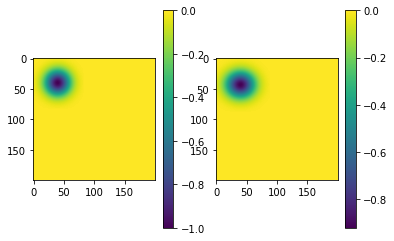

In [67]:
plt.subplot(1,2,1)
plot_2d_f(torch_mod_to_fcn(true_bf), n_smps_per_dim=200)
plt.subplot(1,2,2)
plot_2d_f(torch_mod_to_fcn(fit_bf), n_smps_per_dim=200)

# Now we look at fitting more complicated functions 

In [74]:
fcn_generator = F_t(n_bumps = 20, bump_peak_vl_range = [-1, 1], cov_ev_range = [.005, .01])
f_true = fcn_generator.generate()

x = np.random.rand(4000,2)
y = f_true(x)

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

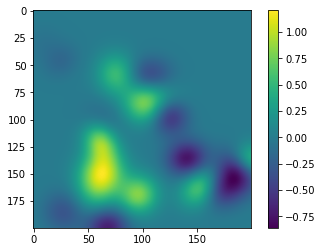

In [75]:
plot_2d_f(f_true, n_smps_per_dim=200)

## Fit a new sum of bump functions to the data

In [104]:
fit_sf = SumOfBumpFcns(40,support_p=.01)

In [105]:
lr = .01
center_k = .0001 #.01
mag_k = .000001 #.0001
bandwidth_k = .000001 #.0001
enforce_bounds=True
batch_size = 100

t0 = time.time()

fit(fit_sf, x, y, n_its = 501, lr=lr, batch_size=batch_size, center_k=center_k, mag_k=mag_k, 
    bandwidth_k=bandwidth_k, enforce_bounds=enforce_bounds, 
    update_int=500)
for i in range(0):
    fit(fit_sf, x, y, n_its = 3001, lr=lr, batch_size=batch_size, center_k=center_k, mag_k=mag_k, 
        bandwidth_k=bandwidth_k, enforce_bounds=enforce_bounds, 
        update_int=1000)
    
t_stop = time.time()

print('Elapsed time: ' + str(t_stop - t0))

It 0: 1.204034e-01
It 500: 9.009268e-04
Elapsed time: 8.177072286605835


In [106]:
fit_sf = fit_sf.to('cpu') 
x = x.to('cpu')
y = y.to('cpu')

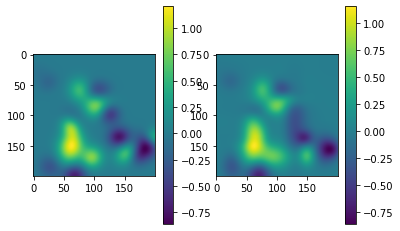

In [107]:
plt.subplot(1,2,1)
plot_2d_f(f_true, n_smps_per_dim=200)
plt.subplot(1,2,2)
plot_2d_f(torch_mod_to_fcn(fit_sf), n_smps_per_dim=200)